In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as K
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-04-17 14:43:36.385898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading the Data

In [2]:
with h5py.File("info/data/output_signal.h5", "r") as file:
    signal_data = file["events"][:]

with h5py.File("info/data/output_bg.h5", "r") as file:
    bg_data = file["events"][:]

In [3]:
# storing signal and background data in panda DataFrame
signal = pd.DataFrame(signal_data)
background = pd.DataFrame(bg_data)

# concatenating the data frames to be part of one big set
df = pd.concat([signal, background])

# reseting the indicies
df = df.reset_index()

# creating the labels for the data sets i.e; signal = 1, background = 0 for classification
labels = np.concatenate([np.ones(signal.shape[0]), np.zeros(background.shape[0])])
labels = pd.DataFrame({'ttZ': labels})

# adding labels as a column at the end of the DataFrame
df = df.join(labels)

# shuffling the DataFrame
df_shuffled = df.sample(frac=1, random_state=42)  # 'random_state' for reproducibility
df_shuffled.head()

# splitting the labels from the rest of the dataset
y = df_shuffled['ttZ']

# we can check the class distribution in the subset
print('ttZ events: {:.2f}%'.format(np.sum(y)/len(y) * 100))
print('WZ events: {:.2f}%'.format((1 - np.sum(y)/len(y)) * 100))

ttZ events: 68.65%
WZ events: 31.35%


# Various Feature Lists

In [4]:
# base input list suggested by the project
input_list = [ "H_T",
              "jet_1_pt",
              "jet_2_pt",
              "lep_1_pt",
              "lep_2_pt",
              "n_bjets",
              "jet_1_twb",
              "jet_2_twb",
              "bjet_1_pt"]

# best input list suggested by SRS 
input_list_2 = ['jet_1_pt', 
                'jet_3_pt', 
                'jet_1_eta', 
                'jet_3_eta', 
                'jet_1_twb', 
                'jet_2_twb', 
                'jet_3_twb', 
                'bjet_1_pt', 
                'n_jets', 
                'n_bjets',
                'n_leptons']

# smallest input list that still has an accuracy >80%, suggested by SRS
input_list_3 = ['jet_3_pt',
                'jet_1_twb',
                'jet_2_twb',
                'jet_3_twb',
                'bjet_1_pt',
                'n_jets',
                'n_bjets']

input_lists = [input_list, input_list_2, input_list_3]

# Defining Model Function

In [5]:
def build_model(lr=0.002, layer1=25, layer2=12, layer3=5):
    model = K.Sequential([
        preprocessing_layer,
        K.layers.Dense(layer1, activation="relu"),
        K.layers.Dense(layer2, activation="relu"),
        K.layers.Dense(layer3, activation="relu"),
        K.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=K.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Importing Best Results

In [6]:
# from model_selection.ipynb
results = pd.read_csv('model_selection.csv')
results

,Unnamed: 0,base list,SRS: best list,SRS: best smallest list
0,batch_size,300.0000,100.0000,150.0000
1,model__layer1,50.0000,25.0000,50.0000
2,model__layer2,12.0000,25.0000,50.0000
3,model__layer3,10.0000,15.0000,5.0000
4,model__optimizer__lr,0.0020,0.0020,0.0002
5,best score,0.8296,0.8339,0.8270


# Feature Importance through Permutations

In [7]:
# Function to calculate permutation feature importance
def permutation_importance(model, X_valid, y_valid, metric=accuracy_score):
    
    # Store the baseline accuracy of the model on original data
    baseline_accuracy = metric(y_valid, model.predict(X_valid).round())
    
    # accuracy decreases will be stored here
    importances = []

    # iterations over each feature
    for i in range(X_valid.shape[1]):  
        save = X_valid[:, i].copy()

        # shuffle individual feature
        X_valid[:, i] = shuffle(X_valid[:, i])
        m_accuracy = metric(y_valid, model.predict(X_valid).round())

        # restore original data
        X_valid[:, i] = save

        # store decrease in accuracy for feature i
        importances.append(baseline_accuracy - m_accuracy)

    return np.array(importances)

# Running Best Models For Each Feature List And Ranking their Feature Importances

Printing summary of the trained model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 50)                500       
                                                                 
 dense_1 (Dense)             (None, 12)                612       
                                                                 
 dense_2 (Dense)             (None, 10)                130       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,272
Trainable params: 1,253
Non-trainable params: 19
______________

/var/folders/3x/lv7sddxn2gg8mq0dwdcn1wg40000gn/T/ipykernel_79200/1070017733.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs2[i].set_xticklabels(df['Label'], rotation=45)


2318/2318 [==============================] - 1s 402us/step
base list
0.8290854168352347
Printing summary of the trained model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 25)                300       
                                                                 
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 dense_6 (Dense)             (None, 15)                390       
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                           

/var/folders/3x/lv7sddxn2gg8mq0dwdcn1wg40000gn/T/ipykernel_79200/1070017733.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs2[i].set_xticklabels(df['Label'], rotation=45)


2318/2318 [==============================] - 1s 368us/step
SRS: best list
0.839482698168676
Printing summary of the trained model:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 7)                15        
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 50)                400       
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 5)                 255       
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                       

/var/folders/3x/lv7sddxn2gg8mq0dwdcn1wg40000gn/T/ipykernel_79200/1070017733.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs2[i].set_xticklabels(df['Label'], rotation=45)


2318/2318 [==============================] - 1s 378us/step
SRS: best smallest list
0.8313240014024867


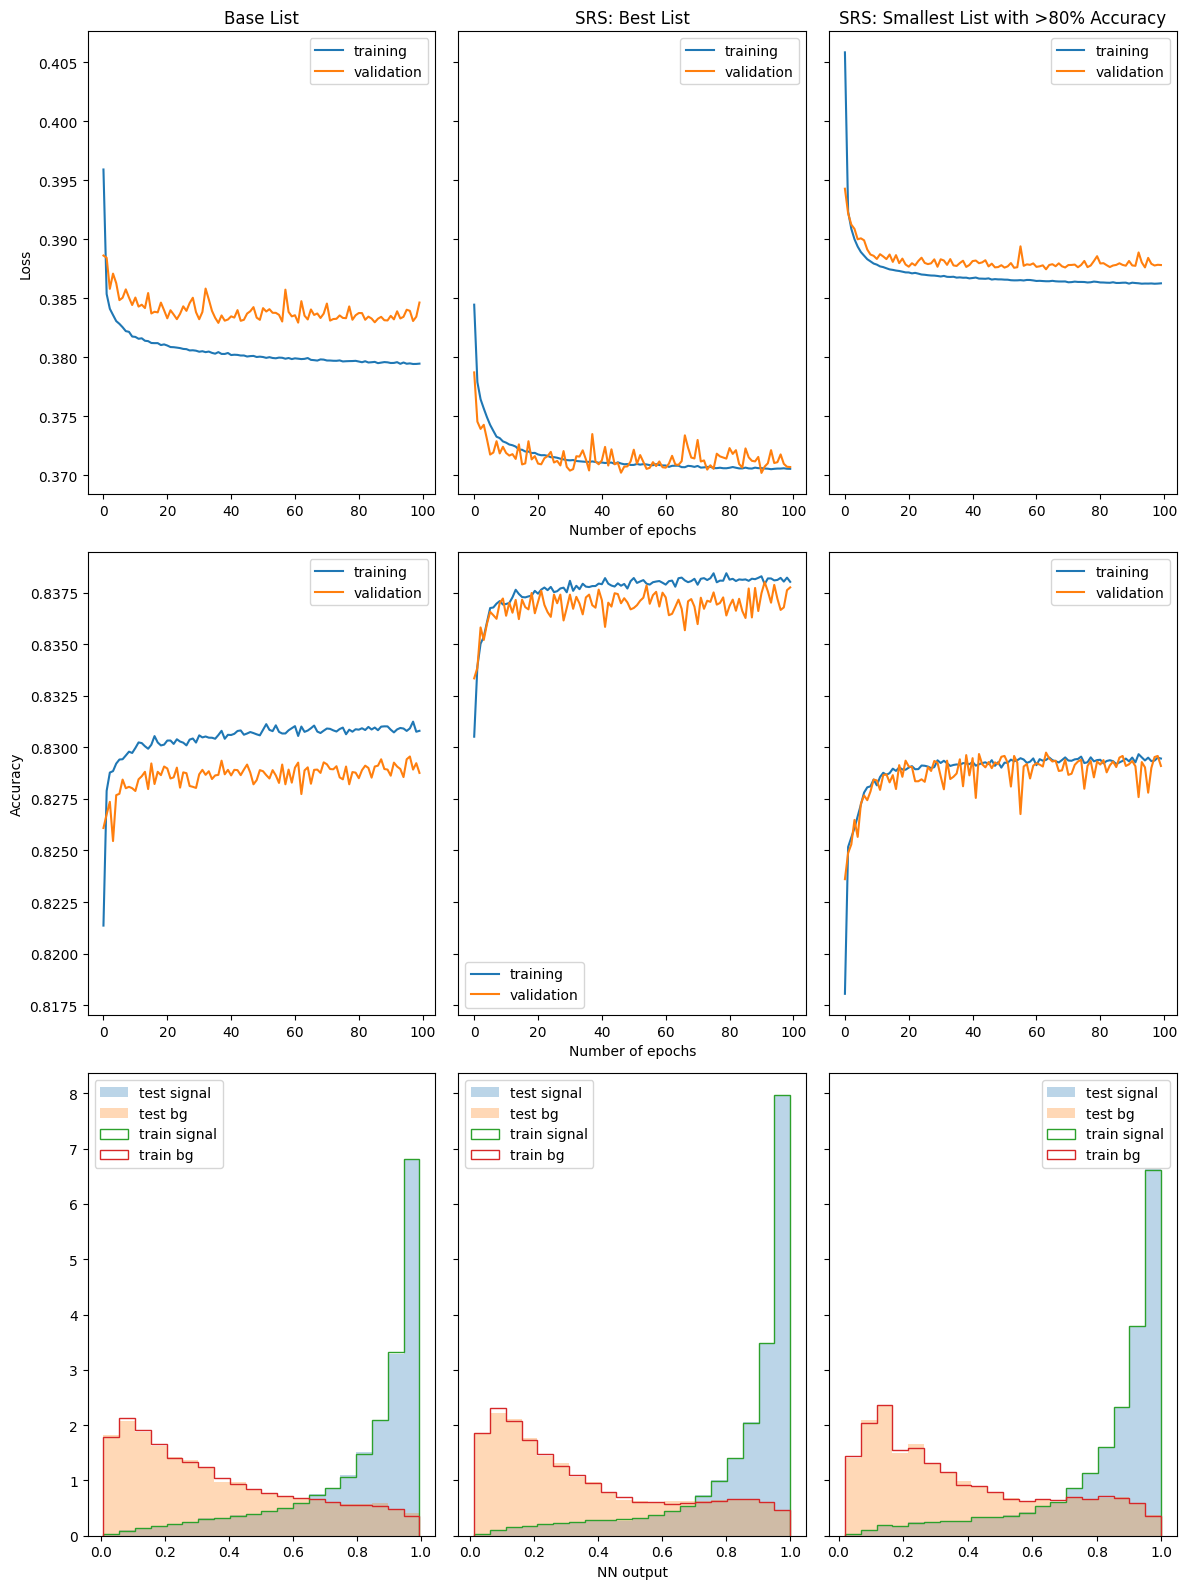

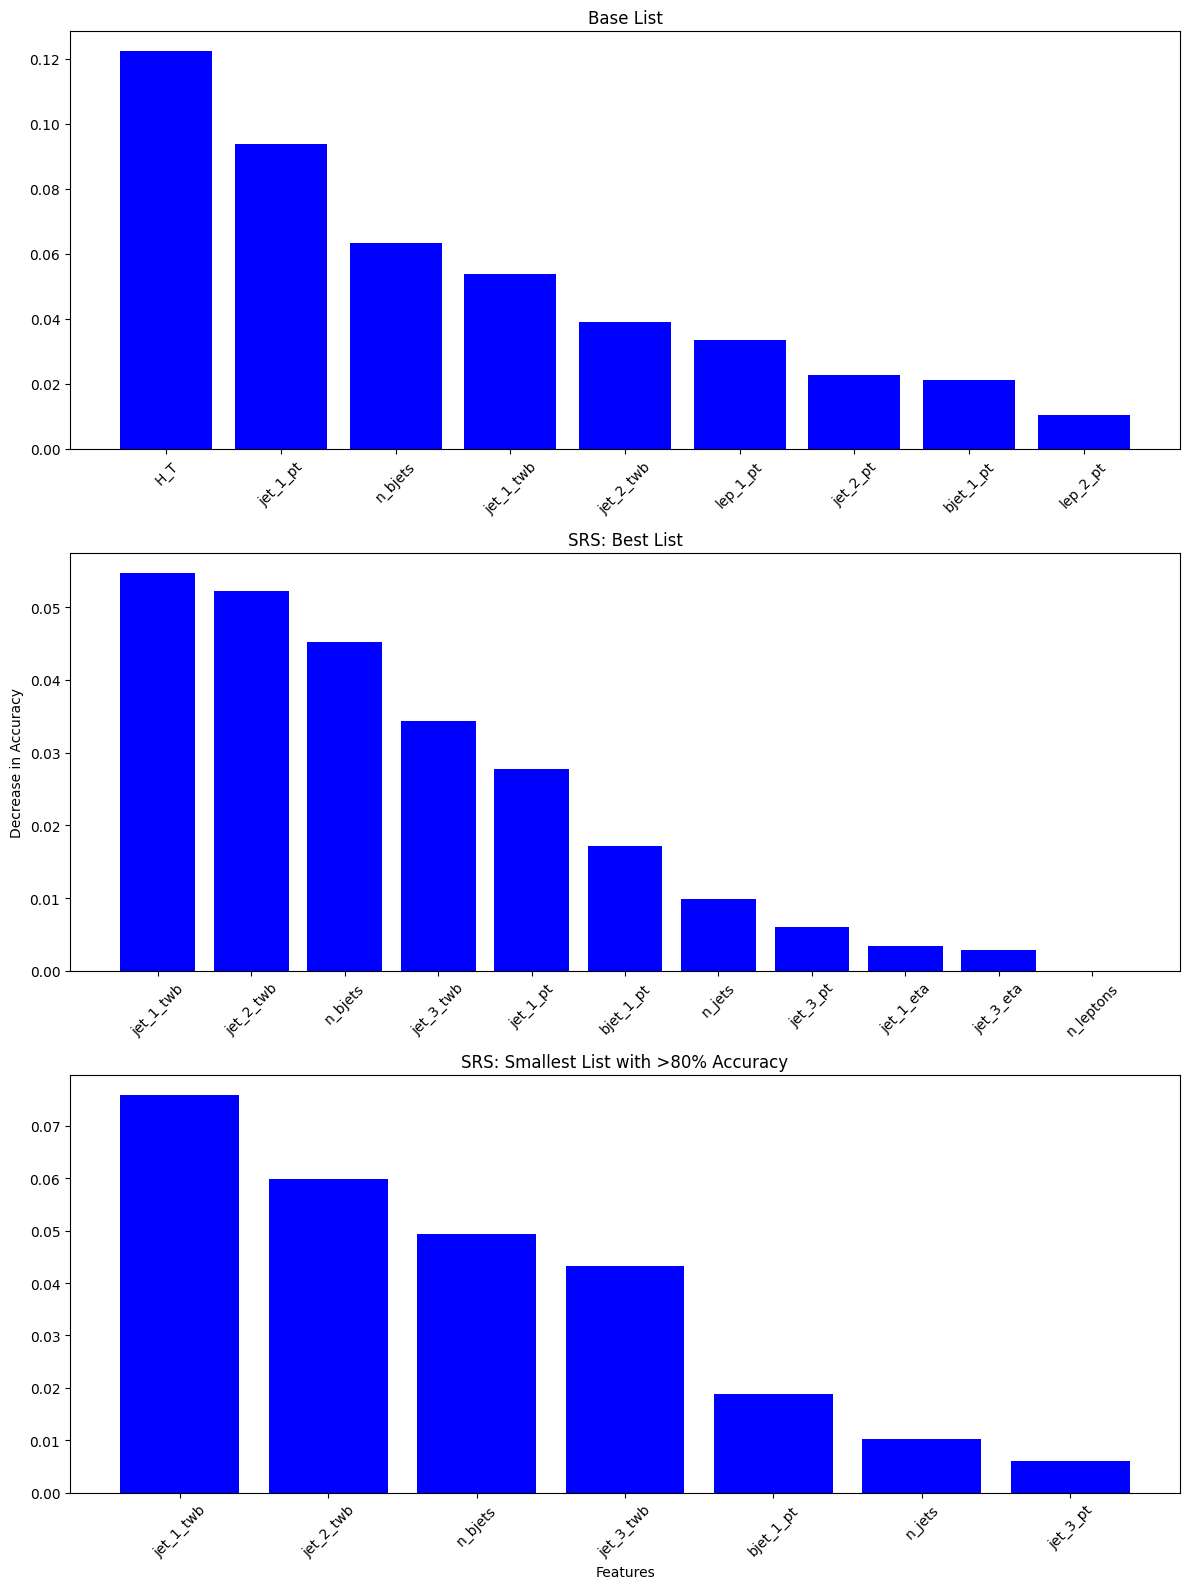

In [8]:
# fig for all best model performances from each feature list
fig, axs = plt.subplots(3, 3, figsize=(12, 16), sharey='row')

#
fig2, axs2 = plt.subplots(3, 1, figsize=(12, 16))

for i, feature_list in enumerate(input_lists):
    names = ['base list', 'SRS: best list', 'SRS: best smallest list']

    ## train, test, val splits
    X = df_shuffled[feature_list]
    x_train, x_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
    x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, train_size=0.5)

    ## building model
    preprocessing_layer = K.layers.Normalization()
    preprocessing_layer.adapt(x_train)

    model = build_model(lr=results[names[i]][4],
                        layer1=int(results[names[i]][1]),
                        layer2=int(results[names[i]][2]),
                        layer3=int(results[names[i]][3]))

    # fitting model
    fit_history = model.fit(
        x_train,
        y_train,
        batch_size=int(results[names[i]][0]),
        epochs=100,
        validation_data=(x_val, y_val),
        verbose = 0)

    
    print("Printing summary of the trained model:")
    print(model.summary())

    titles = ['Base List', 'SRS: Best List', 'SRS: Smallest List with >80% Accuracy']
    
    # plotting performance results
    axs[0, i].plot(fit_history.history["loss"], label="training")
    axs[0, i].plot(fit_history.history["val_loss"], label="validation")
    axs[0, i].legend()
    axs[0, i].set_title(titles[i])

    axs[1, i].plot(fit_history.history["accuracy"], label="training")
    axs[1, i].plot(fit_history.history["val_accuracy"], label="validation") 
    axs[1, i].legend()

    _, bins, _ = axs[2, i].hist(model.predict(x_test[y_test.astype(bool)]), bins=20, alpha=0.3, density=True, label="test signal")
    axs[2, i].hist(model.predict(x_test[~y_test.astype(bool)]), bins=bins, alpha=0.3, density=True, label="test bg")
    axs[2, i].hist(model.predict(x_train[y_train.astype(bool)]), bins=bins, density=True, histtype="step", label="train signal")
    axs[2, i].hist(model.predict(x_train[~y_train.astype(bool)]), bins=bins, density=True, histtype="step", label="train bg")
    axs[2, i].legend()

    if i == 0:
            axs[0, i].set_ylabel("Loss")
            axs[1, i].set_ylabel("Accuracy")
            
    elif i == 1:
        axs[0, i].set_xlabel("Number of epochs")
        axs[1, i].set_xlabel("Number of epochs")
        axs[2, i].set_xlabel("NN output")


    # plotting feature rankings through the permutation method
    feature_importances = permutation_importance(model, x_test.to_numpy(), y_test.to_numpy())

    # Sorting the features by importance
    df = pd.DataFrame({'Label': x_test.columns, 'Value': feature_importances})
    df = df.sort_values('Value', ascending=False)

    # Plotting the sorted data
    axs2[i].bar(df['Label'], df['Value'], color='blue')
    axs2[i].set_xticklabels(df['Label'], rotation=45)
    axs2[i].set_title(titles[i])
    
    if i == 1:
        axs2[i].set_ylabel('Decrease in Accuracy')
    elif i == 2:
        axs2[i].set_xlabel('Features')
    
    # evaluating test sets 
    probs = model.predict(x_test)
    y_pred = (probs > 0.5).astype(int)
    print(names[i])
    print(accuracy_score(y_test, y_pred))

fig.tight_layout()
fig.savefig("best_models.pdf")

fig2.tight_layout()
fig2.savefig("feature_importances.pdf")

plt.show()